# Tugas Besar Teknik Penambangan Data
## Jakarta Air Quality Index (AQI) Classification

### Anggota Kelompok:
- **Kevin Philips Tanamas** - 220711789
- **Richard Angelico Pudjohartono** - 220711747
- **Dhiaz Juan** - 220711695
- **Nathanael Esmond** - 220711888

---

### Deskripsi:
Proyek ini bertujuan untuk mengklasifikasikan Indeks Kualitas Udara (AQI) Jakarta berdasarkan data yang diambil dari berbagai stasiun pemantauan kualitas udara di Jakarta. Dengan menggunakan teknik penambangan data dan algoritma pembelajaran mesin, proyek ini akan memprediksi kategori kualitas udara Jakarta berdasarkan konsentrasi polutan utama seperti PM10, PM25, SO2, CO, O3, dan NO2.

Data yang digunakan berasal dari file pengukuran AQI yang mencakup rentang waktu dari tahun 2010 hingga 2023. Setiap entri dalam dataset mencatat nilai konsentrasi polutan untuk setiap hari dan stasiun pemantauan. Tujuan utama dari proyek ini adalah untuk mengembangkan model prediksi yang dapat mengklasifikasikan kualitas udara ke dalam kategori seperti "BAIK", "SEDANG", dan "TIDAK SEHAT" berdasarkan nilai maksimum konsentrasi polutan.


## DATA LOADING

In [1]:
# Import semua library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from pandas.api.types import is_numeric_dtype
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from collections import Counter
import lightgbm as lgb

/home/jupyter-220711789/Data_Mining/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Data Loading
all_data = pd.read_csv(r"ispu_dki_all.csv")
all_data.head(10)

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
0,2010-01-01,DKI1 (Bunderan HI),60.0,NaN,4.0,73.0,27.0,14.0,73.0,CO,SEDANG
1,2010-01-02,DKI1 (Bunderan HI),32.0,NaN,2.0,16.0,33.0,9.0,33.0,O3,BAIK
2,2010-01-03,DKI1 (Bunderan HI),27.0,NaN,2.0,19.0,20.0,9.0,27.0,PM10,BAIK
3,2010-01-04,DKI1 (Bunderan HI),22.0,NaN,2.0,16.0,15.0,6.0,22.0,PM10,BAIK
4,2010-01-05,DKI1 (Bunderan HI),25.0,NaN,2.0,17.0,15.0,8.0,25.0,PM10,BAIK
5,2010-01-06,DKI1 (Bunderan HI),30.0,NaN,3.0,22.0,19.0,11.0,30.0,PM10,BAIK
6,2010-01-07,DKI1 (Bunderan HI),41.0,NaN,4.0,24.0,27.0,13.0,41.0,PM10,BAIK
7,2010-01-08,DKI1 (Bunderan HI),64.0,NaN,8.0,51.0,19.0,15.0,64.0,PM10,SEDANG
8,2010-01-09,DKI1 (Bunderan HI),55.0,NaN,5.0,39.0,23.0,16.0,55.0,PM10,SEDANG
9,2010-01-10,DKI1 (Bunderan HI),34.0,NaN,5.0,23.0,26.0,12.0,34.0,PM10,BAIK


In [3]:
# Menambahkan atribut rata-rata polutan per hari dan indikator weekend/weekday

all_data['rata_rata_polutan'] = all_data[['pm10', 'so2', 'co', 'o3', 'no2']].mean(axis=1)
all_data['tanggal'] = pd.to_datetime(all_data['tanggal'])
all_data['weekday_weekend'] = all_data['tanggal'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

In [4]:
# Konversi datetime dan hapus kolom 'tanggal'

all_data['year'] = pd.to_datetime(all_data['tanggal']).dt.year
all_data['month'] = pd.to_datetime(all_data['tanggal']).dt.month
all_data['day'] = pd.to_datetime(all_data['tanggal']).dt.day
all_data.drop(columns=['tanggal'], inplace=True)

## EXPLORATORY DATA ANALYSIS (EDA) 

In [5]:
numerical_cols = ['pm10', 'so2', 'co', 'o3', 'no2', 'rata_rata_polutan']

In [6]:
# Visualisasi Distribusi Kolom Numerik
alt.Chart(all_data).transform_fold(
    numerical_cols,
    as_=['Variable', 'Value']
).mark_area(
    opacity=0.5
).encode(
    alt.X('Value:Q', bin=alt.Bin(maxbins=30)),
    alt.Y('count()'),
    alt.Color('Variable:N')
).properties(
    title='Distribution of Numerical Columns',
    width=600,
    height=400
).interactive()

alt.Chart(...)

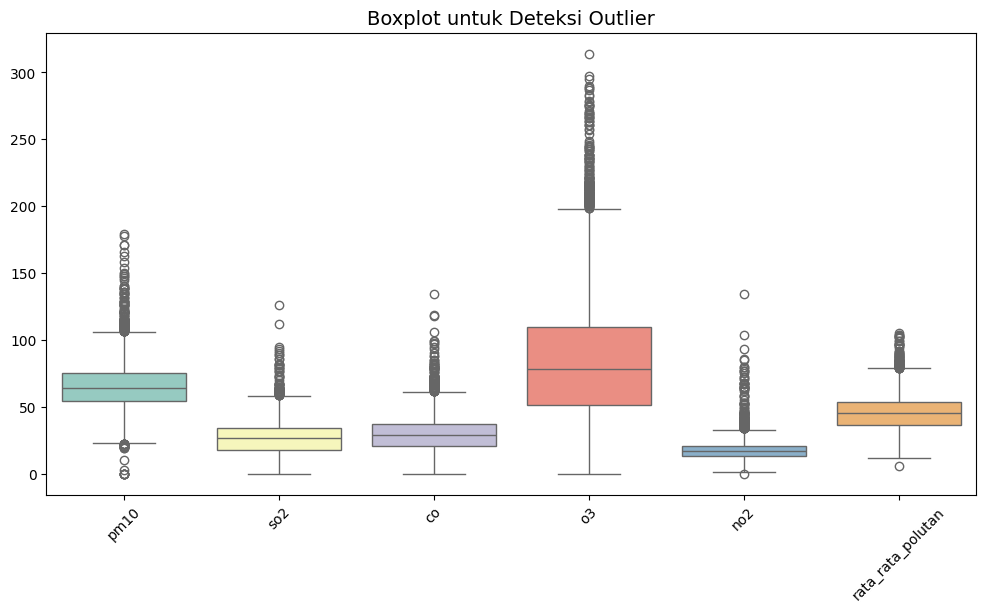

In [7]:
# Visualisasi Outlier
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_data[numerical_cols], palette='Set3')
plt.title('Boxplot untuk Deteksi Outlier', fontsize=14)
plt.xticks(rotation=45)
plt.show()

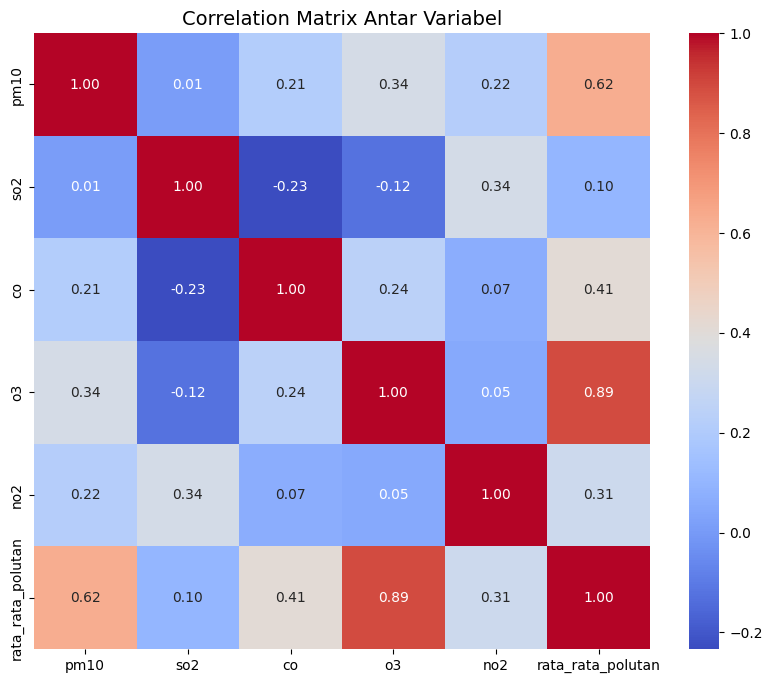

In [8]:
# Visualisasi Heatmap Korelasi Antar Variabel

plt.figure(figsize=(10, 8))
corr_matrix = all_data[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix Antar Variabel', fontsize=14)
plt.show()


In [9]:
# Visualisasi Rata-rata polutan dari waktu ke waktu
temp_df = all_data
temp_df['datetime'] = pd.to_datetime(all_data[['year', 'month', 'day']])

alt.Chart(temp_df).mark_line().encode(
    x=alt.X('datetime:T', title='Waktu'),
    y=alt.Y('rata_rata_polutan:Q', title='Rata-rata Polutan'),
    tooltip=['datetime:T', 'average_pollutant:Q']
).properties(
    title='Rata-rata Polutan dari Waktu ke Waktu',
    width=800,
    height=400
).interactive()

alt.Chart(...)

In [10]:
# Visualisasi Categori dari Waktu ke Waktu

data_categori = all_data.groupby(['year', 'month', 'categori']).size().reset_index(name='count')

chart = alt.Chart(data_categori).mark_bar().encode(
    x=alt.X('month:O', title='Month'), 
    y=alt.Y('count:Q', title='Count'),
    color='categori:N',  
    column='year:O',  
).properties(
    title='Distribusi Kategori Kualitas Udara Jakarta dari Waktu ke Waktu'
)

chart.show()

alt.Chart(...)

## DATA CLEANSING/MISSING VALUE HANDLING


Jakarta Highest AQI Data Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4626 entries, 0 to 4625
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   stasiun            4626 non-null   object        
 1   pm10               4466 non-null   float64       
 2   pm25               723 non-null    float64       
 3   so2                4607 non-null   float64       
 4   co                 4618 non-null   float64       
 5   o3                 4621 non-null   float64       
 6   no2                4618 non-null   float64       
 7   max                4626 non-null   float64       
 8   critical           4625 non-null   object        
 9   categori           4626 non-null   object        
 10  rata_rata_polutan  4625 non-null   float64       
 11  weekday_weekend    4626 non-null   object        
 12  year               4626 non-null   int32         
 13  month              4626 non-

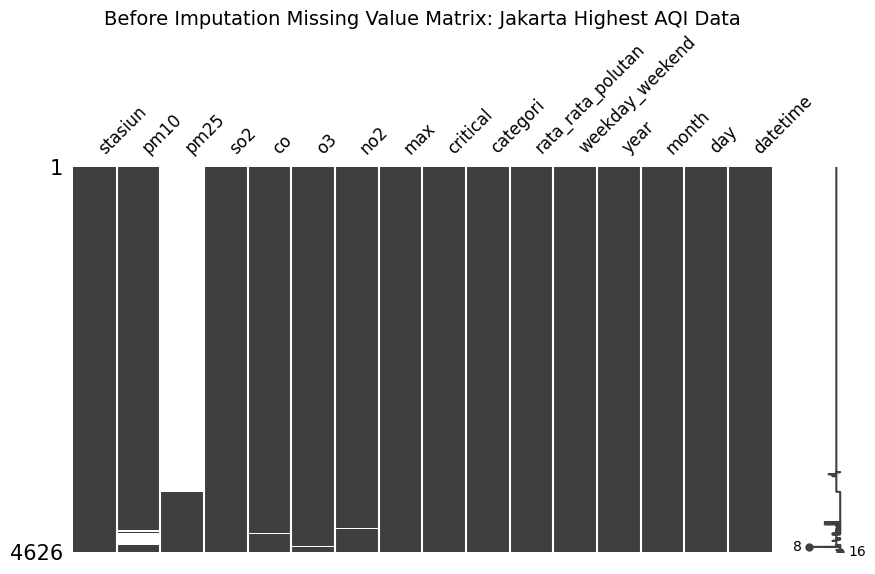

In [11]:
# Preprocessing Data - Missing Value (sebelum imputasi)
datasets = {
    "Jakarta Highest AQI Data": all_data
}

for name, data in datasets.items():
    print(f"\n{name} Dataset:")
    print(data.info())
    print("\nMissing Value Report:")
    print(data.isnull().sum())

    msno.matrix(data, figsize=(10, 5), fontsize=12)
    plt.title(f"Before Imputation Missing Value Matrix: {name}", fontsize=14)
    plt.show()

In [12]:
# Preprocessing Data - Data Cleansing pada all_data
all_data.drop(columns=['pm25'], inplace=True)

numerical_columns = all_data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    all_data[col] = all_data[col].fillna(all_data[col].mean())

categorical_columns = all_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

print(all_data.isnull().sum())

stasiun              0
pm10                 0
so2                  0
co                   0
o3                   0
no2                  0
max                  0
critical             0
categori             0
rata_rata_polutan    0
weekday_weekend      0
year                 0
month                0
day                  0
datetime             0
dtype: int64



Jakarta Highest AQI Data Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4626 entries, 0 to 4625
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   stasiun            4626 non-null   object        
 1   pm10               4626 non-null   float64       
 2   so2                4626 non-null   float64       
 3   co                 4626 non-null   float64       
 4   o3                 4626 non-null   float64       
 5   no2                4626 non-null   float64       
 6   max                4626 non-null   float64       
 7   critical           4626 non-null   object        
 8   categori           4626 non-null   object        
 9   rata_rata_polutan  4626 non-null   float64       
 10  weekday_weekend    4626 non-null   object        
 11  year               4626 non-null   int32         
 12  month              4626 non-null   int32         
 13  day                4626 non-

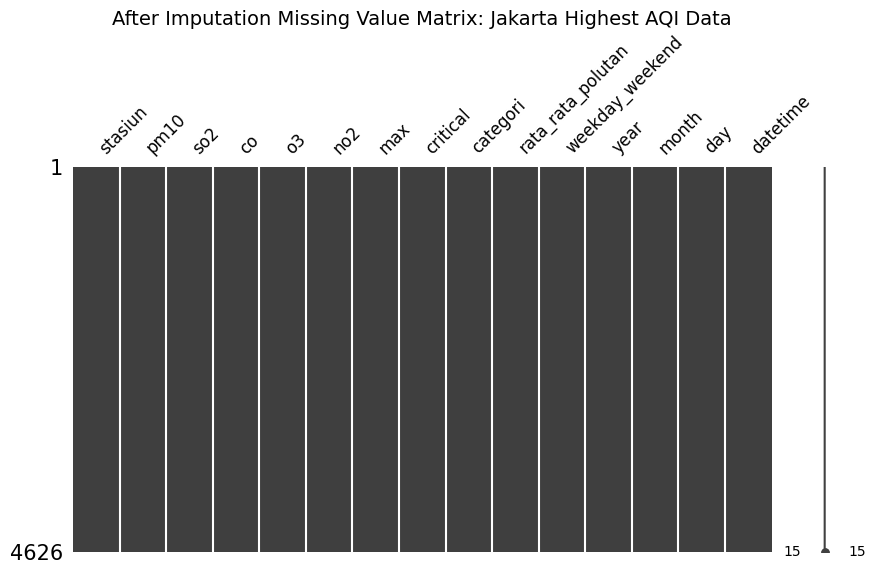

In [13]:
# Preprocessing Data - Missing Value (sesudah imputasi dan dropping)
datasets = {
    "Jakarta Highest AQI Data": all_data
}

for name, data in datasets.items():
    print(f"\n{name} Dataset:")
    print(data.info())
    print("\nMissing Value Report:")
    print(data.isnull().sum())

    msno.matrix(data, figsize=(10, 5), fontsize=12)
    plt.title(f"After Imputation Missing Value Matrix: {name}", fontsize=14)
    plt.show()

In [14]:
all_data.head(10)

,stasiun,pm10,so2,co,o3,no2,max,critical,categori,rata_rata_polutan,weekday_weekend,year,month,day,datetime
0,DKI1 (Bunderan HI),60.0,4.0,73.0,27.0,14.0,73.0,CO,SEDANG,35.6,Weekday,2010,1,1,2010-01-01
1,DKI1 (Bunderan HI),32.0,2.0,16.0,33.0,9.0,33.0,O3,BAIK,18.4,Weekend,2010,1,2,2010-01-02
2,DKI1 (Bunderan HI),27.0,2.0,19.0,20.0,9.0,27.0,PM10,BAIK,15.4,Weekend,2010,1,3,2010-01-03
3,DKI1 (Bunderan HI),22.0,2.0,16.0,15.0,6.0,22.0,PM10,BAIK,12.2,Weekday,2010,1,4,2010-01-04
4,DKI1 (Bunderan HI),25.0,2.0,17.0,15.0,8.0,25.0,PM10,BAIK,13.4,Weekday,2010,1,5,2010-01-05
5,DKI1 (Bunderan HI),30.0,3.0,22.0,19.0,11.0,30.0,PM10,BAIK,17.0,Weekday,2010,1,6,2010-01-06
6,DKI1 (Bunderan HI),41.0,4.0,24.0,27.0,13.0,41.0,PM10,BAIK,21.8,Weekday,2010,1,7,2010-01-07
7,DKI1 (Bunderan HI),64.0,8.0,51.0,19.0,15.0,64.0,PM10,SEDANG,31.4,Weekday,2010,1,8,2010-01-08
8,DKI1 (Bunderan HI),55.0,5.0,39.0,23.0,16.0,55.0,PM10,SEDANG,27.6,Weekend,2010,1,9,2010-01-09
9,DKI1 (Bunderan HI),34.0,5.0,23.0,26.0,12.0,34.0,PM10,BAIK,20.0,Weekend,2010,1,10,2010-01-10


## PENGECEKAN DATA DUPLIKAT

In [15]:
# Pengecekan data duplikat
print("Before checking for duplicates: ", all_data.shape)
all_data = all_data[~all_data.duplicated(keep='last')]
print("After checking for duplicates: ", all_data.shape)

Before checking for duplicates:  (4626, 15)
After checking for duplicates:  (4626, 15)


## PEMBERSIHAN OUTLIER

In [16]:
# Pembersihan Data Outlier memakai IQR

cols = ['pm10', 'so2', 'co', 'o3', 'no2', 'rata_rata_polutan']

def remove_outlier(df_in, cols):
    df_out = df_in.copy()
    for col_name in cols:
        if is_numeric_dtype(df_out[col_name]): 
            q1 = df_out[col_name].quantile(0.25)
            q3 = df_out[col_name].quantile(0.75)
            iqr = q3 - q1
            upper_bound = q3 + (iqr * 1.5)
            lower_bound = q1 - (iqr * 1.5)

            df_out = df_out[(df_out[col_name] >= lower_bound) & (df_out[col_name] <= upper_bound)]
    return df_out

all_data_cleaned = remove_outlier(all_data, cols)
print("Number of rows before removing outliers: ", all_data.shape[0])
print("Number of rows after removing outliers: ", all_data_cleaned.shape[0])

Number of rows before removing outliers:  4626
Number of rows after removing outliers:  3957


In [17]:
# Overfitting Handling (membuang data categori yang jumlahnya < 10)

print(all_data_cleaned['categori'].value_counts())
threshold = 10
category_counts = all_data_cleaned['categori'].value_counts()
valid_categories = category_counts[category_counts >= threshold].index
filtered_data = all_data_cleaned[all_data_cleaned['categori'].isin(valid_categories)]
print(filtered_data['categori'].value_counts())

categori
SEDANG                2367
TIDAK SEHAT           1317
BAIK                   270
SANGAT TIDAK SEHAT       2
TIDAK ADA DATA           1
Name: count, dtype: int64
categori
SEDANG         2367
TIDAK SEHAT    1317
BAIK            270
Name: count, dtype: int64


## DATA ENCODING

In [18]:
# Label Encoding untuk Data Non-Numerik
label_encoder = LabelEncoder()
filtered_data['stasiun'] = label_encoder.fit_transform(filtered_data['stasiun'])
filtered_data['critical'] = label_encoder.fit_transform(filtered_data['critical'])
filtered_data['weekday_weekend'] = label_encoder.fit_transform(filtered_data['weekday_weekend'])
# all_data_cleaned['categori'] = all_data_cleaned['categori'].replace({'SEDANG': 0, 'BAIK': 1, 'TIDAK SEHAT': 2})
filtered_data['categori'] = label_encoder.fit_transform(filtered_data['categori'])
filtered_data.drop(columns=['datetime'], inplace=True)

/tmp/ipykernel_3247704/1626848811.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['stasiun'] = label_encoder.fit_transform(filtered_data['stasiun'])
/tmp/ipykernel_3247704/1626848811.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['critical'] = label_encoder.fit_transform(filtered_data['critical'])
/tmp/ipykernel_3247704/1626848811.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

## DATA MODELING

Beberapa algoritma pembelajaran mesin yang akan digunakan dalam proyek ini antara lain:

1. **Support Vector Machine (SVM)**  
   Digunakan untuk mengklasifikasikan data berdasarkan batas keputusan yang optimal.

2. **LightGBM (LGBM)**  
   Algoritma gradient boosting yang efisien untuk menangani data besar dan fitur yang kompleks.

3. **Random Forest (RF)**  
   Algoritma ensemble yang menggabungkan keputusan dari banyak pohon keputusan untuk meningkatkan akurasi prediksi.


In [19]:
# Feature Scaling & Train-test split

x = filtered_data.drop(['categori', 'stasiun'], axis = 1).values
y = filtered_data.categori.values

# Normalisasi Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.25, random_state=15)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2965, 12)
(989, 12)
(2965,)
(989,)


In [20]:
# Suport Vector Machine Model

svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Model Training
svm_model.fit(x_train, y_train)

# Predictions
y_pred_svm = svm_model.predict(x_test)
y_pred_svm_proba = svm_model.predict_proba(x_test)

print("Building Model SVM...")
print(classification_report(y_test, y_pred_svm))

Building Model SVM...
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        77
           1       0.94      0.98      0.96       578
           2       0.97      0.96      0.97       334

    accuracy                           0.95       989
   macro avg       0.95      0.89      0.91       989
weighted avg       0.95      0.95      0.95       989



In [21]:
# Random Forest Model

rf_model = RandomForestClassifier(n_estimators=100)

rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

print("Building Model Random Forest...")
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Building Model Random Forest...
Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00       578
           2       1.00      1.00      1.00       334

    accuracy                           1.00       989
   macro avg       1.00      1.00      1.00       989
weighted avg       1.00      1.00      1.00       989



In [22]:
# Light Gradient-Boosting Machine Model

lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5, reg_alpha=0.0, reg_lambda=0.0, verbosity=-1,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

lgb_model.fit(x_train, y_train)
y_pred_lgb = lgb_model.predict(x_test)

print("Building Model LGBM...")
print(classification_report(y_test, y_pred_lgb))

Building Model LGBM...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00       578
           2       1.00      1.00      1.00       334

    accuracy                           1.00       989
   macro avg       1.00      1.00      1.00       989
weighted avg       1.00      1.00      1.00       989



## EVALUASI MODEL

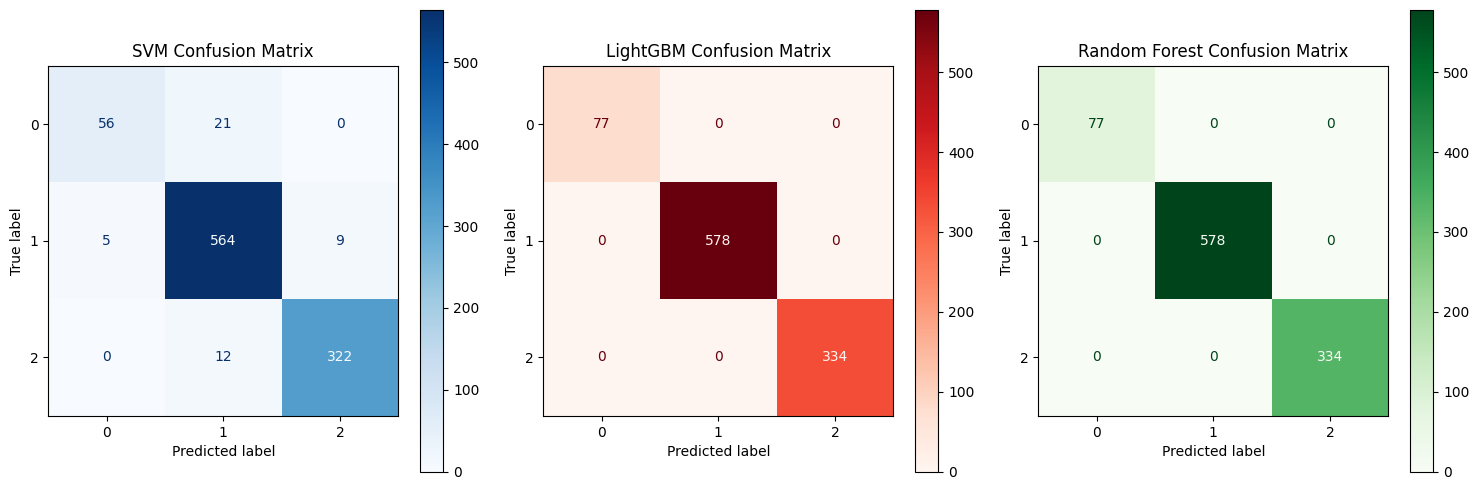

In [23]:
# Confusion Matrix untuk Evaluasi Model

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=svm_model.classes_)
cm_lgb = confusion_matrix(y_test, y_pred_lgb, labels=lgb_model.classes_)
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_)

disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_model.classes_)
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=lgb_model.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

disp_svm.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('SVM Confusion Matrix')

disp_lgb.plot(ax=axes[1], cmap='Reds')
axes[1].set_title('LightGBM Confusion Matrix')

disp_rf.plot(ax=axes[2], cmap='Greens')
axes[2].set_title('Random Forest Confusion Matrix')

plt.tight_layout()
plt.show()

In [24]:
# Evaluasi Model - Cross Validation Score

rf_scores = cross_val_score(rf_model, x_train, y_train, cv=5, scoring='accuracy')
print("RF Cross-validation scores:", rf_scores)
print("RF Mean cross-validation score:", rf_scores.mean())

RF Cross-validation scores: [1.         1.         1.         0.99831366 1.        ]
RF Mean cross-validation score: 0.9996627318718382


In [25]:
# Evaluasi Model - Cross Validation Score

svm_scores = cross_val_score(svm_model, x_train, y_train, cv=5, scoring='accuracy')
print("SVM Cross-validation scores:", svm_scores)
print("SVM Mean cross-validation score:", svm_scores.mean())

SVM Cross-validation scores: [0.95109612 0.96121417 0.95109612 0.9544688  0.96458685]
SVM Mean cross-validation score: 0.9564924114671165


In [26]:
# Evaluasi Model - Cross Validation Score

lgb_scores = cross_val_score(lgb_model, x_train, y_train, cv=5, scoring='accuracy')
print("LGBM Cross-validation scores:", lgb_scores)
print("LGBM Mean cross-validation score:", lgb_scores.mean())

LGBM Cross-validation scores: [1. 1. 1. 1. 1.]
LGBM Mean cross-validation score: 1.0
